In [1]:
%env CUDA_VISIBLE_DEVICES=3


env: CUDA_VISIBLE_DEVICES=3


In [2]:
#-*- coding:utf-8 -*-
import os
import json
import threading
import numpy as np
from PIL import Image

import tensorflow as tf
import keras
from keras import losses
from keras import backend as K
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Reshape, Masking, Lambda, Permute
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

from imp import reload
import densenet


Using TensorFlow backend.


train/model


In [3]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset_dir,list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 characters='', shuffle=True,maxLabelLength=10):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.characters = characters
        self.n_classes = len(self.characters)
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataset_dir = dataset_dir
        self.maxLabelLength = maxLabelLength

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float)
        Y = np.zeros([self.batch_size, self.maxLabelLength],dtype=int) 
        input_length = np.zeros([self.batch_size, 1])
        label_length = np.zeros([self.batch_size, 1])
        
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            try:
                img = Image.open(os.path.join(self.dataset_dir, ID)).convert('L')
                img = img.resize((self.dim[1],self.dim[0]))
                img = np.array(img, 'f') / 255.0 - 0.5
            except (OSError,IOError) as error:
                print(error)
                img = np.zeros(*self.dim,dtype=np.float)
                

            X[i,] = np.expand_dims(img, axis=2)
            
            label_origin = self.labels[ID]
            label_origin.replace(' ','')
            label = self.__one_hot(label_origin,length=len(label_origin))


            if(len(label) <= 0):
                print("%s label len < 0" %ID)
            # the input length for ctc_loss, for densenet pool size is about 8
            label_length[i] = len(label)
            input_length[i] = self.dim[1] // 8
            Y[i, :len(label)] = label
    
            
        inputs = {'the_input': X,
            'the_labels': Y,
            'input_length': input_length,
            'label_length': label_length,
            }
        outputs = {'ctc': np.zeros([self.batch_size])}
        return inputs, outputs

    def __one_hot(self, text,length):
        length = min(length,self.maxLabelLength)
        label = np.zeros(length)
        for i, char in enumerate(text):
            index = self.characters.find(char)
            if index == -1:
                index = self.characters.find(u'.')
            if i < length:
                label[i] = index
        return label



In [23]:
import json
import sys 
sys.path.append('/mnt/wuwenhui/git_ocr_project/chinese_ocr_densenet/densenet/')
import keys


img_h = 32
img_w = 280
batch_size = 128
maxlabellength = 10


label_path = './images/medicine_dataset_v3/'
# label_valid_path  = './images/medicine_dataset_v3/'
with open(label_path+'train_label.json','r',encoding='utf-8') as json_file:
    label_dict_train=json.load(json_file)

with open(label_path+'valid_label.json','r',encoding='utf-8') as json_file:
    label_dict_valid=json.load(json_file)


len(label_dict_train),len(label_dict_valid)



(218730, 11294)

In [74]:
train_id = list(label_dict_train.keys())
valid_id = list(label_dict_valid.keys())
# characters = keys.alphabet[:]
characters = keys.alphabet_union[1:]+'卍'
# characters = ''.join([ch.strip('\n') for ch in characters][1:] + ['卍'])
nclass = len(characters)
print(nclass)
train_generator = DataGenerator(dataset_dir=label_path+'train/', list_IDs=train_id, 
                                labels=label_dict_train,batch_size = batch_size, characters=characters,
                                dim=(img_h,img_w),maxLabelLength=maxlabellength)
valid_generator = DataGenerator(dataset_dir=label_path+'valid/', list_IDs=valid_id, 
                                labels=label_dict_valid,batch_size = batch_size, characters=characters,
                                dim=(img_h,img_w),maxLabelLength=maxlabellength)

6711


119
(128, 1) [694 419 557 893  45  47  72  70   5   5]


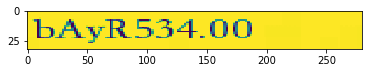

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
train_generator.on_epoch_end()
iterator = iter(train_generator)

X,y = iterator.__next__()
i = np.random.randint(0,X['the_labels'].shape[0])
# train_generator.on_epoch_end()
print(i)
print(X['input_length'].shape,X['the_labels'][i])
image = np.squeeze(X['the_input'][i])
plt.imshow(image)



In [15]:
import imp 
imp.reload(densenet)
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def get_model(img_h, nclass):
    input = Input(shape=(img_h, None, 1), name='the_input')
    y_pred = densenet.dense_cnn(input, nclass)

    basemodel = Model(inputs=input, outputs=y_pred)
    basemodel.summary()

    labels = Input(name='the_labels', shape=[None], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input, labels, input_length, label_length], outputs=loss_out)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])

    return basemodel, model




In [79]:

# char_set = open('char_std_5990.txt', 'r', encoding='utf-8').readlines()
# char_set = ''.join([ch.strip('\n') for ch in char_set][1:] + ['卍'])
nclass = len(characters)
print(len(characters))
# K.set_session(get_session())
reload(densenet)
basemodel, model = get_model(img_h, nclass)

modelPath = './models/weights_densenet_union_with_num-27-0.84.h5'
if os.path.exists(modelPath):
    print("Loading model weights...")
    model.load_weights(modelPath)
    print('done!')






6711
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 32, None, 1)  0                                            
__________________________________________________________________________________________________
conv2d_352 (Conv2D)             (None, 16, None, 64) 1600        the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_352 (BatchN (None, 16, None, 64) 256         conv2d_352[0][0]                 
__________________________________________________________________________________________________
activation_352 (Activation)     (None, 16, None, 64) 0           batch_normalization_352[0][0]    
__________________________________________________________________________________________________
conv2

Loading model weights...
done!


In [81]:


checkpoint = ModelCheckpoint(filepath='./models/weights_densenet_union_with_num-{epoch:02d}-{val_acc:.2f}.h5', monitor='val_loss', save_best_only=False, save_weights_only=True)
lr_schedule = lambda epoch: 0.006 * 0.95**epoch
learning_rate = np.array([lr_schedule(i) for i in range(100)])
changelr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))
earlystop = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./models/logs', write_graph=True)

print(lr_schedule)
print('-----------Start training-----------')
model.fit_generator(train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 100,
    initial_epoch = 0,
    validation_data = valid_generator,
    callbacks = [checkpoint, earlystop, changelr, tensorboard])


<function <lambda> at 0x7f27b19fe510>
-----------Start training-----------
Epoch 1/100
1708/1708 [==============================] - 1260s 738ms/step - loss: 0.8246 - acc: 0.8400 - val_loss: 3.2200 - val_acc: 0.7873
Epoch 2/100
1708/1708 [==============================] - 1243s 728ms/step - loss: 0.7842 - acc: 0.8485 - val_loss: 3.2000 - val_acc: 0.7968
Epoch 3/100
1708/1708 [==============================] - 1246s 730ms/step - loss: 0.7622 - acc: 0.8519 - val_loss: 2.9645 - val_acc: 0.7983
Epoch 4/100
1708/1708 [==============================] - 1243s 728ms/step - loss: 0.7418 - acc: 0.8557 - val_loss: 3.1694 - val_acc: 0.7917
Epoch 5/100
1708/1708 [==============================] - 1248s 731ms/step - loss: 0.7199 - acc: 0.8588 - val_loss: 2.9466 - val_acc: 0.7829
Epoch 6/100
1708/1708 [==============================] - 1244s 728ms/step - loss: 0.6976 - acc: 0.8620 - val_loss: 3.0989 - val_acc: 0.8113
Epoch 7/100
1708/1708 [==============================] - 1257s 736ms/step - loss: 0.6